# Text 2: Latent semantic indexing
**Internet Analytics - Lab 4**

---

**Group:** *J*

**Names:**

* *Maxime Lucas Lanvin*
* *Victor Salvia*
* *Erik Axel Wilhelm Sjöberg*

---

#### Instructions

*This is a template for part 2 of the lab. Clearly write your answers, comments and interpretations in Markdown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

In [1]:
# Import Libraries
import pickle
import numpy as np
from scipy.sparse.linalg import svds
from utils import load_json
from numpy.linalg import norm

# Import LibEx1
import nltk
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.util import ngrams 
from utils import load_json, load_pkl
import copy
from collections import Counter
from scipy.sparse import csr_matrix
# from numpy.linalg import norm

# Import Data
courses = load_json('data/courses.txt')
stopwords = load_pkl('data/stopwords.pkl')

[nltk_data] Downloading package wordnet to /home/lanvin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import utils

## Functions From Part 1 to get the TF-IDF Matrix X

In [3]:
# Constructs a term-document matrix from a corpus
def get_term_document_matrix(corpus):
    global_dictionary, dictionary_mapping = get_dictionary(corpus)
    df_index = dict((k,len(list(set(v)))) for k,v in dictionary_mapping.items()) # A dict where the key is the term and the value is in how many documents the term is present
    unique_words = list(df_index.keys()) #The unique words
    word_to_index = dict(zip(unique_words,(range(len(unique_words))))) # Mapping from word to index (That we use for the encoding)
    index_to_word = dict((v,k) for k,v in word_to_index.items()) # Mapping back from index to word. 


    m = len(unique_words)
    n = len(corpus)

    values = []
    rows = []
    columns = []

    for i in range(n):
        tokens = corpus[i]['description']
        loc_word_count = len(tokens)
        loc_counts = Counter(tokens)
        unique_tokens = list(loc_counts.keys())

        for token in unique_tokens:
            tf = loc_counts[token]/loc_word_count
            df = df_index[token]
            idf = np.log(n/(df+1))

            rows.append(word_to_index[token])
            columns.append(i)
            values.append(tf*idf)

    return csr_matrix((values, (rows, columns)), shape=(m, n)), index_to_word, word_to_index

def get_column_scores(mat, i,index_to_word, n=-1):
    a = mat.getcol(i)
    non_zero_rows = csr_matrix.nonzero(a)[0]
    d = {}
    for i in non_zero_rows:
        d[index_to_word[i]] = a[i,0]
    order_d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    if n == -1:
        return Counter(order_d).most_common()
    else:
        return Counter(order_d).most_common(n)
    
def get_row_scores(mat, word,word_to_index, n=-1,corpus=courses):
    a = mat.getrow(word_to_index[word])
    non_zero_cols = csr_matrix.nonzero(a)[1]
    d = {}
    for i in non_zero_cols:
        d[corpus[i]['name']] = a[0,i]
    
    order_d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    if n == -1:
        return Counter(order_d).most_common()
    else:
        return Counter(order_d).most_common(n)
    
# We do not care for the position here so just add them up
def corpus_merge(c1,c2):
    merged_corpus =  copy.deepcopy(c1)
    for i in range(len(c1)):
        merged_corpus[i]['description'] = merged_corpus[i]['description'] + c2[i]['description']
    return merged_corpus

# Checks whether or not there is a digit in a string.
def NoNumbers(s):
    return not any(char.isdigit() for char in s)

# Stemms a given string
def stemmer(s):
    word_tokens = tknzr.tokenize(s)
    temp_list = [ps.stem(w) for w in word_tokens if not w in ignored_words] 
    return [w for w in temp_list if NoNumbers(w)]

# Lemmatizes a given string
def lemmazation(s):
    word_tokens = tknzr.tokenize(s)
    temp_list = [lemmatizer.lemmatize(w) for w in word_tokens if not w in ignored_words]
    return [w for w in temp_list if NoNumbers(w)]

def lem_n_stem(s):
    word_tokens = tknzr.tokenize(s)
    temp_list = [ps.stem(lemmatizer.lemmatize(w)) for w in word_tokens if not w in ignored_words]
    return [w for w in temp_list if NoNumbers(w)]    

# Helper function for the tokenize_1gram.
# tokenzie a given string, either stem or Lemmatise the words and removes the ignored words for a 1 gram
def tokenize_1gram(l,lem,stemlem):
    courses_loc = copy.deepcopy(l)
    for i in courses_loc:
        description = i['description']
        if lem == True:
            i['description'] = lemmazation(description)
            if stemlem == False:
                i['description'] = lemmazation(description)
            else:
                i['description'] = lem_n_stem(description)
        else:
            i['description'] = stemmer(description)  
    return courses_loc

# Description: Tokenzie a given string, either stem or Lemmatise the words and removes the ignored words for a 1 gram.
# After this step n-grams are created over the cleaned string //

# @ l: Indicats the level of the n-gram we want returned over the string l. Default is 1.
# @ lem: boolean exression determining whether or not to use stemming or lemmazation. Default is lemmazation
# @ stemlem: boolean expression determining whether or not to use both stemming and lemmazation
def tokenize_ngram(l,n=1,lem=True,stemlem=False):
    if n ==1:
        return tokenize_1gram(l,lem,stemlem)  
    courses_loc = copy.deepcopy(l)
    for i in courses_loc:
        description = i['description']
        sentences = description.split('.')
        grams = []
        for s in sentences:
            if lem == True:
                if stemlem == False:
                    tokens = lemmazation(s)
                else:
                    tokens = lem_n_stem(s)
            else:
                tokens = stemmer(s)
            grams = grams + list(ngrams(tokens,n))
        i['description'] = grams
    return courses_loc   

def get_dictionary(d):
    global_dictionary = []
    dictionary_mapping = {}
    for i in range(0,len(d)):
        temp_list = d[i]
        global_dictionary = global_dictionary + temp_list['description']
        for w in temp_list['description']:
            if w in dictionary_mapping:
                dictionary_mapping[w].append(i)
            else:
                dictionary_mapping[w] = [i]
    return global_dictionary, dictionary_mapping



# Creating a list containing all of the special chars. This list is then added to the stopwords and together they form
# the ignored words. These words will be removed from the corpus. 
specialchar = ['.', ',', '(', ')', '&', ':', '/','-','"',';','', ' ', '..', '...',"'",'%']
ignored_words = set(list(stopwords) + specialchar)


# Creating the tokenizer, the stemmer and the lemmatizer.
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True,preserve_case=False)
ps = PorterStemmer() 
lemmatizer = WordNetLemmatizer()
    
# Tokenzing, Lemmatizing & Stemming the corpus, for 1-grams, 2-grams and 3-grams
lem_and_stem_1gram = tokenize_ngram(courses,1,stemlem=True)
lem_and_stem_2gram = tokenize_ngram(courses,2,stemlem=True)

lem_stem_corpus = corpus_merge(lem_and_stem_1gram, lem_and_stem_2gram)

## Exercise 4.4: Latent semantic indexing

Apply SVD with K = 300 to your term-document matrix X from the previous exercise.
1. Describe the rows and columns of U andV, and the values of S.
2. Print the top-20 eigenvalues of X.

In [4]:
# 1.
X, index_to_word, word_to_index = get_term_document_matrix(lem_stem_corpus)
U, S, V_t = svds(X, k=300)

Here is the interpretation of the rows and columns of U, V, S
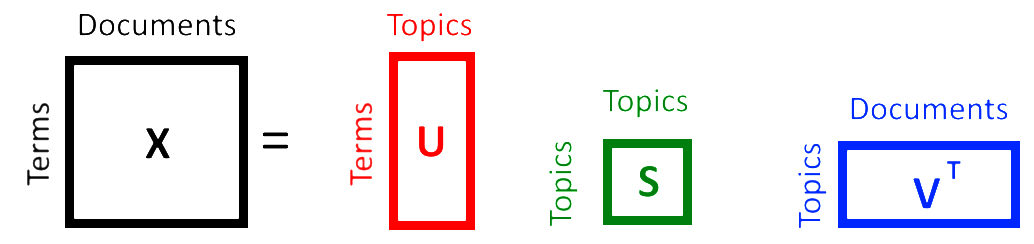

We know that $ \sqrt{\lambda_i} = \sigma_i$, thus to compute the eigenvalues we will square the singular values

In [73]:
# 2.
eigenval_X = S*S
print('The top 20 eigenvalues of X are : \n')
for i, val in enumerate(eigenval_X[-20::][::-1]):print("  #"+str(i+1)+" :\t"+str(val))

The top 20 eigenvalues of X are : 

  #1 :	7.493258662964626
  #2 :	7.170461868512117
  #3 :	4.5599374441253095
  #4 :	1.7236374869619666
  #5 :	1.1362565456542901
  #6 :	0.882142842630598
  #7 :	0.8321259862318432
  #8 :	0.7493043691098814
  #9 :	0.7171353323620919
  #10 :	0.6723092125297008
  #11 :	0.6490587181886455
  #12 :	0.6380568006074502
  #13 :	0.6330746709642352
  #14 :	0.6273587387256975
  #15 :	0.6145480726605501
  #16 :	0.6099360337323447
  #17 :	0.594747618633006
  #18 :	0.5872792148045666
  #19 :	0.5795788378678971
  #20 :	0.5766188861696018


## Exercise 4.5: Topic extraction

Extract the topics from the term-document matrix X using the low-rank approximation.
1. Print the top-10 topics as a combination of 10 terms and 10 documents.
2. Give a label to each of them.

In [6]:
# 1. & 2.
# Convert index to Document
doc_to_index = dict([course['name'], i] for i, course in enumerate(courses))
index_to_doc = dict([i, course['name']] for i, course in enumerate(courses))

# Collect 10 Best Terms related to Top 10 Topics
rates_Terms_topics = np.sum(U[::,-10::], axis=1)
Top_Terms_indices = rates_Terms_topics.argsort()[::-1][:10:]
Top_Terms = [index_to_word[index] for index in Top_Terms_indices]

# Collect 10 Best Documents related to Top 10 Topics
rates_Documents_topics = np.sum(V_t.T[::,-10::], axis=1)
Top_Documents_indices = rates_Documents_topics.argsort()[::-1][:10:]
Top_Documents = [index_to_doc[index] for index in Top_Documents_indices]

In [7]:
# Display Results
print("\n              TOP 10 Topics as combination of 10 Terms and 10 Documents       \n")
print("----------------------------------------------------------------------------------")
print("No  :		Terms                                     Documents")
print("----------------------------------------------------------------------------------")
for i, top_val in enumerate(zip(Top_Terms, Top_Documents)):
    print('#'+str(i+1)+"  :\t\t"+str(top_val[0])+' '*(50-len('#'+str(i+1)+"  :\t\t"+str(top_val[0])+' '))+str(top_val[1]))


              TOP 10 Topics as combination of 10 Terms and 10 Documents       

----------------------------------------------------------------------------------
No  :		Terms                                     Documents
----------------------------------------------------------------------------------
#1  :		('project', 'ic')                         Medicinal chemistry
#2  :		('ic', 'laboratori')                      Magnetic confinement
#3  :		('semest', 'project')                     Project 2 (EDIC)
#4  :		ic                                        Project 1 (EDIC)
#5  :		('provid', 'fondament')                   Plasma Diagnostics in Basic Plasma Physics Devices and Tokamaks: from Principles to Practice
#6  :		('compound', 'drug')                      Plasma physics III
#7  :		('question', 'chemic')                    Some problems in the theory of simple groups
#8  :		('fondament', 'question')                 Plasma instabilities
#9  :		('drug', '?')                             

## Exercise 4.6: Document similarity search in concept-space

Implement a search function using LSI concept-space, and search for "markov chains" and
"facebook".
1. Display the top five courses together with their similarity score for each query.
2. Compare with the previous section.

In [14]:
def sim(term, document, U, S,  V):
    """
    :input: 
        :term: a term
        :document: name of a document
        :U: Left Matrix of the SVD Decomposition
        :S: Diagonal Matrix containing the singular values of the SVD Decomposition
        :V: Right Matrix of the SVD Decomposition
    :output:
        :s: the measure of similarity between the provided term and docucment
    """
    t = word_to_index[term]
    d = doc_to_index[document]
    s = U[t]@S@V[d].T/(norm(U[t])*norm(S@V[d].T))
    return s

def search(word):
    """
    :input: 
        :word: a term
    :output:
        :: Display the TOP 5 courses and their similarity score, related to the provided theme 
    """
    # Compute the TF-IDF Matrix
    X, index_to_word, word_to_index = get_term_document_matrix(lem_stem_corpus)
    # Perform the SVD decomposition with k=300
    U, S, V_t = svds(X, k=300)
    # List of the courses
    courses_list = np.array([c['name'] for c in courses])
    # Compute Similarity
    sim_word_Documents = []
    for course_name in courses_list:
        s = sim(word,course_name, U, np.diag(S), V_t.T)
        sim_word_Documents.append([s, course_name])
    
    # Find 5 most similar courses
    sim_word_Documents.sort()
    sim_courses = sim_word_Documents[-5::][::-1]
    
    # Display Found courses
    
    print("\n              TOP 5 courses about the topic : "+str(word)+"       \n")
    print("----------------------------------------------------------------------------------")
    print("No  :		Courses                                   Similarity Score")
    print("----------------------------------------------------------------------------------")
    for i, top_val in enumerate(sim_courses):
        print('#'+str(i+1)+"  :\t\t"+str(top_val[1])+' '*(50-len('#'+str(i+1)+"  :\t\t"+str(top_val[1])+' '))+str(round(top_val[0],4)))
    
    
    return sim_courses

In [15]:
courses_markov_chains = search(('markov', 'chain'))
courses_facebook = search("facebook")


              TOP 5 courses about the topic : ('markov', 'chain')       

----------------------------------------------------------------------------------
No  :		Courses                                   Similarity Score
----------------------------------------------------------------------------------
#1  :		Applied stochastic processes              0.9113
#2  :		Markov chains and algorithmic applications0.7728
#3  :		Applied probability & stochastic processes0.7409
#4  :		Optimization and simulation               0.4377
#5  :		Statistical Sequence Processing           0.4153

              TOP 5 courses about the topic : facebook       

----------------------------------------------------------------------------------
No  :		Courses                                   Similarity Score
----------------------------------------------------------------------------------
#1  :		Computational Social Media                0.9823
#2  :		Social media                              0.788
#3  :	

In the Part 1, we got the following courses :

In [10]:
print("""
---------------------- markov chains ------------------------
Applied stochastic processes: 0.1592
Markov chains and algorithmic applications: 0.0929
Applied probability & stochastic processes: 0.0849
Optimization and simulation: 0.0472
Networks out of control: 0.0307
""")


---------------------- markov chains ------------------------
Applied stochastic processes: 0.1592
Markov chains and algorithmic applications: 0.0929
Applied probability & stochastic processes: 0.0849
Optimization and simulation: 0.0472
Networks out of control: 0.0307



We found almost the same courses as the last section.

## Exercise 4.7: Document-document similarity

Find the classes that are the most similar to Internet Analytics.
1. Write down the equation to efficiently compute the similarity between documents.
2. Print the top 5 classes most similar to COM-308.

The equation to efficiently compute the similarity between documents is :
$$sim(d,d')= \frac{v_{d}.v_{d'}}{||v_{d}||.||v_{d'}||}$$

In [71]:
def sim_doc(doc1, doc2, V):
    """
    :input: 
        :doc1: name of a document
        :doc2: name of a document
        :V: Right Matrix of the SVD Decomposition
    :output:
        :s: the measure of similarity between the doc1 and doc2
    """
    d1 = doc_to_index[doc1]
    d2 = doc_to_index[doc2]
    s = np.dot(V[d1],V[d2])/(norm(V[d1])*norm(V[d2]))
    return s

def search_courses(course):
    """
    :input: 
        :course: The name of a course
    :output:
        :: Display the TOP 5 courses and their similarity score, related to the provided course name 
    """
    # Compute the TF-IDF Matrix
    X, index_to_word, word_to_index = get_term_document_matrix(lem_stem_corpus)
    # Perform the SVD decomposition with k=300
    U, S, V_t = svds(X, k=300)
    # Index of the given course
    id_course = doc_to_index[course]
    # List of the courses
    courses_list = np.array([c['name'] for c in courses if c['name']!=course])
    # Compute Similarity
    sim_course = []
    for course_name in courses_list:
        s = sim_doc(course, course_name, V_t.T)
        sim_course.append([s, course_name])
    
    # Find 5 most similar courses
    sim_course.sort()
    sim_courses = sim_course[-5::][::-1]
    
    # Display Found courses
    
    print("\n              TOP 5 courses similar to "+str(course)+"       \n")
    print("-------------------------------------------------------------------------------------------------")
    print("No  :		Courses                                                       Similarity Score")
    print("-------------------------------------------------------------------------------------------------")
    for i, top_val in enumerate(sim_courses):
        print('#'+str(i+1)+"  :\t\t"+str(top_val[1])+' '*(70-len('#'+str(i+1)+"  :\t\t"+str(top_val[1])+' '))+str(round(top_val[0],4)))
    
    
    return sim_courses

In [72]:
courses_IX = search_courses("Internet analytics")


              TOP 5 courses similar to Internet analytics       

-------------------------------------------------------------------------------------------------
No  :		Courses                                                       Similarity Score
-------------------------------------------------------------------------------------------------
#1  :		Distributed information systems                               0.6239
#2  :		A Network Tour of Data Science                                0.6113
#3  :		Computational Social Media                                    0.6066
#4  :		Applied data analysis                                         0.5642
#5  :		Human language technology: applications to information access 0.5492
